In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch
from scipy import stats
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.gridspec as gridspec
from PIL import Image, ImageOps
# sns.set()
# sns.set_palette("Paired")
sns.set_style("white")
import math
from datetime import datetime
from datetime import date
import geopandas as gpd
from shapely import wkt

In [124]:
## load raw datasets
dir_path = os.getcwd()
raw_2020 = pd.read_csv(dir_path + "/2020 listings.csv")
raw_2019 = pd.read_csv(dir_path + "/2019 listings.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
# convert the bathroom texts in 2020 data to numerics
temp = np.empty(len(raw_2020))
for i in range(len(raw_2020)):
    if raw_2020["bathrooms_text"][i] == raw_2020["bathrooms_text"][i]:
        if raw_2020["bathrooms_text"][i] in ['Half-bath','Private half-bath','Shared half-bath']:
            temp[i] = 0.5
        else:
            temp[i] = raw_2020["bathrooms_text"][i].split(" ")[0]
    else:
        temp[i] = np.nan
raw_2020["bathrooms"] = temp.astype(float)

In [79]:
## select the relevant columns
cols = ['price','host_since','host_response_time','host_response_rate',\
        'host_is_superhost','host_has_profile_pic','host_identity_verified',\
        'minimum_nights','instant_bookable',\
        'neighbourhood_cleansed','neighbourhood_group_cleansed','property_type','room_type',\
        'accommodates','bathrooms','bedrooms','beds','amenities','number_of_reviews',\
        'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
        'review_scores_communication','review_scores_location','review_scores_value']
full_2020 = raw_2020[cols]
full_2019 = raw_2019[cols]

In [81]:
## remove data with missing information and reset index
full_2020 = full_2020.dropna()
print(len(full_2020.index))
full_2019 = full_2019.dropna()
print(len(full_2019.index))
full_2019 = full_2019.reset_index()
full_2020 = full_2020.reset_index()

15532
27094


In [80]:
## convert relevant features to numerics

# remove the dollar sign in the price variable
full_2020['price'] = full_2020['price'].str[1:].replace(',', '')
full_2020['price'] = full_2020['price'].str.replace(',', '')
full_2020['price'] = full_2020['price'].astype(float)

full_2019['price'] = full_2019['price'].str[1:].replace(',', '')
full_2019['price'] = full_2019['price'].str.replace(',', '')
full_2019['price'] = full_2019['price'].astype(float)

# remove percentage sign in host response rate
full_2020["host_response_rate"] = full_2020["host_response_rate"].str[:-1].astype(int)
full_2019["host_response_rate"] = full_2019["host_response_rate"].str[:-1].astype(int)

# calculate the number of amenities
full_2020["amenities_count"] = full_2020["amenities"].apply(lambda x: x.count(',')+1)
full_2019["amenities_count"] = full_2019["amenities"].apply(lambda x: x.count(',')+1)

# convert host since date to days as host
full_2019['host_history'] = full_2019['host_since']
full_2020['host_history'] = full_2020['host_since']
for i in range(len(full_2019['host_since'])):
    full_2019['host_history'][i] = (date(2019,9,13)-datetime.strptime(full_2019['host_since'][i], "%Y-%m-%d").date()).days
for i in range(len(full_2020['host_since'])):
    full_2020['host_history'][i] = (date(2019,9,13)-datetime.strptime(full_2020['host_since'][i], "%Y-%m-%d").date()).days

45756
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [86]:
# assign categorical columns for property types in 2019 data
other_types = []
for tp in np.unique(full_2019['property_type']):
    full_2019[tp] = 0
    full_2019.loc[(full_2019['property_type']==tp),tp] = 1
    data = full_2019.loc[(full_2019['property_type']==tp)]
    print(tp,len(data.index))
    if len(data.index)<=10:
        other_types.append(tp)
        
# remove listings with 'Other' property type and property types with less than 10 listings
for tp in other_types:
    full_2019.loc[(full_2019['property_type']==tp),'Other'] = 1
    data = full_2019.loc[(full_2019['property_type']==tp)]
full_2019 = full_2019.loc[full_2019['Other']!=1]

Aparthotel 8
Apartment 19892
Barn 1
Bed and breakfast 53
Boat 7
Boutique hotel 116
Bungalow 30
Cabin 1
Camper/RV 11
Condominium 933
Cottage 7
Earth house 4
Farm stay 1
Guest suite 322
Guesthouse 40
Hostel 51
Hotel 124
House 2899
Houseboat 5
Island 1
Loft 933
Nature lodge 1
Other 52
Resort 37
Serviced apartment 259
Tent 4
Tiny house 18
Townhouse 1258
Villa 26


In [88]:
# convert property type in 2020 data to match with 2019 data format
for i in range(len(full_2020.index)):
    if full_2020['property_type'][i].startswith('Entire '):
        full_2020['property_type'][i] = full_2020['property_type'][i][7:].capitalize()
    if full_2020['property_type'][i].startswith('Private room in '):
        full_2020['property_type'][i] = full_2020['property_type'][i][16:].capitalize()
    if full_2020['property_type'][i].startswith('Shared room in '):
        full_2020['property_type'][i] = full_2020['property_type'][i][15:].capitalize()
    if full_2020['property_type'][i].startswith('Room in '):
        full_2020['property_type'][i] = full_2020['property_type'][i][8:].capitalize()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/o

In [90]:
# assign categorical columns to property types in corresponding to property types in 2019 data
for tp in np.unique(full_2019['property_type']):
    if tp not in other_types:
        full_2020[tp] = 0
        full_2020.loc[(full_2020['property_type']==tp),tp] = 1
        data = full_2020.loc[(full_2020['property_type']==tp)]
        print(tp,len(data.index))
        
# remove listings with other property types
other_types_2020 = []
for tp in np.unique(full_2020['property_type']):
    if tp not in np.unique(full_2019['property_type']):
        other_types_2020.append(tp)
    elif tp in other_types:
        other_types_2020.append(tp)
for tp in other_types_2020:
    full_2020.loc[(full_2020['property_type']==tp),'Other'] = 1
full_2020 = full_2020.loc[full_2020['Other']!=1]

Apartment 10583
Bed and breakfast 27
Boutique hotel 190
Bungalow 14
Camper/RV 8
Condominium 602
Guest suite 218
Guesthouse 38
Hostel 51
Hotel 175
House 2026
Loft 465
Resort 17
Serviced apartment 143
Tiny house 9
Townhouse 888
Villa 14


In [95]:
for nbr in np.unique(full_2019['neighbourhood_group_cleansed']):
    full_2019[nbr] = 0
    full_2019.loc[(full_2019['neighbourhood_group_cleansed']==nbr),nbr] = 1
    full_2020[nbr] = 0
    full_2020.loc[(full_2020['neighbourhood_group_cleansed']==nbr),nbr] = 1

In [96]:
full_2019['Entire'] = 0
full_2019.loc[(full_2019['room_type']=='Entire home/apt'),'Entire'] = 1
full_2019['Hotel_room'] = 0
full_2019.loc[(full_2019['room_type']=='Hotel room'),'Hotel_room'] = 1
full_2019['Private'] = 0
full_2019.loc[(full_2019['room_type']=='Private room'),'Private'] = 1
full_2019['Shared'] = 0
full_2019.loc[(full_2019['room_type']=='Shared room'),'Shared'] = 1

In [97]:
full_2020['Entire'] = 0
full_2020.loc[(full_2020['room_type']=='Entire home/apt'),'Entire'] = 1
full_2020['Hotel_room'] = 0
full_2020.loc[(full_2020['room_type']=='Hotel room'),'Hotel_room'] = 1
full_2020['Private'] = 0
full_2020.loc[(full_2020['room_type']=='Private room'),'Private'] = 1
full_2020['Shared'] = 0
full_2020.loc[(full_2020['room_type']=='Shared room'),'Shared'] = 1

In [98]:
binary_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable']

for feat in binary_cols:
    full_2019.loc[(full_2019[feat]=='t'),feat] = 1
    full_2019.loc[(full_2019[feat]=='f'),feat] = 0
    full_2020.loc[(full_2020[feat]=='t'),feat] = 1
    full_2020.loc[(full_2020[feat]=='f'),feat] = 0

In [99]:
# normalize numeric features
norm_cols = ['host_response_rate','number_of_reviews','host_history','accommodates','bathrooms', 'bedrooms','minimum_nights',\
        'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
        'review_scores_communication','review_scores_location','review_scores_value','amenities_count','host_history']
for feat in norm_cols:
    full_2020[feat] = (full_2020[feat] - np.mean(full_2020[feat]))/np.std(full_2020[feat])
    full_2019[feat] = (full_2019[feat] - np.mean(full_2019[feat]))/np.std(full_2019[feat])

# remove listings with price = 0 and calculate log price
full_2019 = full_2019.loc[(full_2019["price"]!=0)]
full_2020 = full_2020.loc[(full_2020["price"]!=0)]

full_2019["log_price"] = np.log(full_2019["price"])
full_2020["log_price"] = np.log(full_2020["price"])

In [100]:
# select features and convert feature types to float
features = ['host_history','host_response_rate',\
        'host_is_superhost','host_has_profile_pic','host_identity_verified',\
        'minimum_nights','instant_bookable',\
        'bathrooms','bedrooms','beds','accommodates','amenities_count',\
        'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
        'review_scores_communication','review_scores_location','review_scores_value','number_of_reviews',\
        'Apartment', 'Bed and breakfast', 'Boutique hotel',\
        'Bungalow', 'Camper/RV', 'Condominium', 'Guest suite', 'Guesthouse', 'Hostel',\
        'Hotel', 'House', 'Loft', 'Resort', 'Serviced apartment', 'Tiny house','Townhouse', 'Villa', \
        'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',\
        'Entire', 'Hotel_room', 'Private', 'Shared']
full_2019[features] = full_2019[features].astype(float)
full_2020[features] = full_2020[features].astype(float)

In [101]:
# feature correlation in 2019 data
corr = full_2019[features].corr()
corr.style.background_gradient(cmap='coolwarm')

,host_history,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,minimum_nights,instant_bookable,bathrooms,bedrooms,beds,accommodates,amenities_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,Apartment,Bed and breakfast,Boutique hotel,Bungalow,Camper/RV,Condominium,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Resort,Serviced apartment,Tiny house,Townhouse,Villa,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire,Hotel_room,Private,Shared
host_history,1.000000,-0.029319,0.073717,0.004186,0.492588,0.057777,-0.247296,-0.033660,-0.009245,-0.059491,-0.046846,0.047987,0.112159,0.107349,0.046330,0.105789,0.119831,0.056322,0.077955,0.226411,0.044299,0.009162,-0.048692,-0.016724,-0.009890,0.002145,-0.013055,-0.008945,-0.016220,-0.091343,-0.084867,0.076944,-0.013496,0.011761,-0.017262,0.023790,-0.023155,-0.059997,0.127786,0.005845,-0.151478,-0.023825,0.089700,-0.105405,-0.048422,-0.065939
host_response_rate,-0.029319,1.000000,0.174404,-0.001351,-0.010077,-0.047031,0.116301,0.025380,0.033352,0.051485,0.046319,0.150583,0.088045,0.091266,0.111221,0.094692,0.111419,0.037970,0.078113,0.101676,-0.050452,-0.012773,-0.008149,0.004619,0.007863,0.008856,0.029056,0.009033,0.014489,-0.027493,0.041536,-0.020161,0.012356,0.006243,-0.005644,0.041324,0.010106,0.020842,0.008234,-0.038537,0.027204,0.017464,0.000026,-0.026654,0.004509,0.002623
host_is_superhost,0.073717,0.174404,1.000000,-0.004578,0.081415,-0.036799,-0.015227,-0.019524,0.013367,0.015302,0.017932,0.249990,0.245682,0.229481,0.271961,0.171423,0.179731,0.102021,0.231576,0.233090,-0.049261,0.002770,-0.011067,-0.010383,0.022139,-0.005217,0.032403,0.003269,-0.027368,-0.037324,0.027718,0.002232,-0.022711,0.051340,0.001262,0.048026,-0.002784,0.011814,0.031049,-0.042213,0.004964,0.016589,0.008775,-0.023657,0.002261,-0.020320
host_has_profile_pic,0.004186,-0.001351,-0.004578,1.000000,0.035611,0.002749,-0.006662,0.008750,0.000726,0.005359,0.006152,0.004844,0.009854,0.009060,0.006202,0.006309,0.008571,-0.007484,0.010558,0.000200,0.003881,0.001967,0.002914,0.001479,0.000896,-0.000771,0.004873,0.001709,0.001930,0.003013,0.001870,-0.009933,0.001643,-0.004219,0.001146,-0.006085,0.001377,0.002752,0.026994,-0.024975,-0.005588,0.004541,0.002236,0.004475,-0.003656,0.001641
host_identity_verified,0.492588,-0.010077,0.081415,0.035611,1.000000,0.037721,-0.177590,-0.034172,-0.004577,-0.027116,-0.015374,0.060368,0.086182,0.083584,0.041303,0.077613,0.087843,0.027701,0.063186,0.174237,0.022704,0.009751,-0.040882,-0.008250,0.014659,-0.003233,-0.005482,-0.004372,-0.034737,-0.054562,-0.051518,0.045622,0.018309,0.031859,-0.015032,0.015934,-0.011675,-0.032422,0.101202,-0.011377,-0.100195,-0.035108,0.062166,-0.078319,-0.039833,-0.022151
minimum_nights,0.057777,-0.047031,-0.036799,0.002749,0.037721,1.000000,-0.067281,0.030743,-0.021570,-0.013950,-0.027309,-0.007846,-0.052393,-0.067348,-0.075352,-0.056354,-0.083201,-0.030531,-0.094732,-0.114036,0.036835,-0.009154,-0.019408,-0.009338,-0.006252,0.016703,-0.022709,-0.006873,-0.010299,-0.021220,-0.050691,-0.010739,-0.007470,0.087190,-0.006792,-0.012726,-0.008424,-0.022300,-0.045598,0.089347,-0.046997,-0.010788,0.083438,-0.017418,-0.073521,-0.021857
instant_bookable,-0.247296,0.116301,-0.015227,-0.006662,-0.177590,-0.067281,1.000000,0.012473,0.003701,0.022086,0.032969,0.016374,-0.074839,-0.057815,-0.034817,-0.060966,-0.064641,-0.041468,-0.047323,0.013945,-0.006133,-0.001826,0.038695,0.001137,0.001557,-0.013005,-0.009773,-0.001291,0.032458,0.041507,0.023179,-0.035630,-0.008960,0.002406,0.010196,-0.008405,0.012525,0.015191,-0.043212,0.003714,0.047331,0.002502,-0.072358,0.084046,0.046992,0.028346
bathrooms,-0.033660,0.025380,-0.019524,0.008750,-0.034172,0.030743,0.012473,1.000000,0.421057,0.377405,0.346077,0.086433,-0.034390,-0.049159,-0.041105,-0.026363,-0.054395,-0.045147,-0.029137,-0.047011,-0.161769,0.007877,

In [104]:
# feature correlation in 2020 data
corr = full_2020[features].corr()
corr.style.background_gradient(cmap='coolwarm')

,host_history,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,minimum_nights,instant_bookable,bathrooms,bedrooms,beds,accommodates,amenities_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,Apartment,Bed and breakfast,Boutique hotel,Bungalow,Camper/RV,Condominium,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Resort,Serviced apartment,Tiny house,Townhouse,Villa,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire,Hotel_room,Private,Shared
host_history,1.000000,0.043710,0.084913,0.028517,0.101294,0.075347,-0.269764,-0.023656,0.005769,-0.033025,-0.015950,0.053032,0.131562,0.144427,0.062409,0.132677,0.152144,0.064868,0.106365,0.229975,0.068626,-0.002342,-0.107996,0.003648,-0.027909,0.013217,-0.004734,-0.013114,-0.047559,-0.132658,-0.078874,0.092716,-0.015355,0.009745,-0.004533,0.030031,-0.016510,-0.064462,0.168843,-0.004207,-0.171934,-0.031946,0.146263,-0.129512,-0.095515,-0.064902
host_response_rate,0.043710,1.000000,0.190481,0.012161,0.039647,0.021027,0.018289,0.008066,0.019570,0.029976,0.019611,0.169832,0.089796,0.099406,0.099457,0.086928,0.096237,0.058714,0.076319,0.069794,-0.021718,-0.036458,-0.007573,0.011280,-0.000970,-0.001204,0.021453,0.009298,-0.007046,-0.069523,0.025909,-0.020023,0.014216,0.026899,-0.006565,0.043907,-0.042829,0.026290,0.016841,-0.040744,0.008761,0.026518,0.039312,-0.049702,-0.022257,-0.016836
host_is_superhost,0.084913,0.190481,1.000000,0.002982,0.010256,-0.069385,-0.068406,-0.019735,0.023977,0.038247,0.034234,0.283430,0.269334,0.256931,0.286801,0.204778,0.215488,0.137669,0.265910,0.218860,-0.042572,-0.000503,-0.068428,0.003254,-0.017665,0.027277,0.069049,0.004595,-0.044665,-0.069192,0.040675,-0.005417,-0.025759,-0.003899,-0.002135,0.052171,0.007692,0.020927,0.072356,-0.104675,0.023163,0.019800,0.044973,-0.054522,-0.023673,-0.026712
host_has_profile_pic,0.028517,0.012161,0.002982,1.000000,0.020630,-0.020003,-0.009225,0.011256,0.005500,-0.015152,-0.015625,0.005720,0.026844,0.031395,0.029871,0.019270,0.037292,0.024783,0.029848,0.001885,-0.009456,-0.027207,0.005888,0.001589,0.001201,0.004276,0.006313,0.002620,0.003037,0.005648,0.013219,-0.005086,0.001751,0.005100,0.001274,-0.008083,0.001589,0.004389,0.018634,-0.017932,-0.005381,0.006043,-0.020345,0.006429,0.016266,0.008480
host_identity_verified,0.101294,0.039647,0.010256,0.020630,1.000000,0.018713,-0.000666,0.016089,-0.002753,0.000610,0.005148,0.045800,-0.005169,-0.010171,0.001245,-0.001517,-0.008112,0.013147,-0.008602,0.029826,0.007098,0.010348,0.010533,-0.015917,0.004857,0.006384,-0.006326,0.003410,-0.028052,0.021157,-0.035547,0.019186,0.012449,-0.002709,-0.007141,0.013273,-0.005403,-0.048322,0.000926,0.060812,-0.045629,-0.028740,-0.015885,0.031597,-0.007153,0.049058
minimum_nights,0.075347,0.021027,-0.069385,-0.020003,0.018713,1.000000,-0.040630,0.058887,0.012308,-0.014154,-0.023403,0.005282,-0.026687,-0.038044,-0.050625,-0.018646,-0.045971,-0.001618,-0.061206,-0.141951,0.038216,-0.014959,-0.032789,-0.009184,-0.010237,0.054118,-0.021628,-0.012948,-0.022222,-0.047291,-0.072120,0.010718,-0.011752,0.073470,-0.009025,0.010329,-0.011483,-0.050679,-0.026207,0.111645,-0.073220,-0.032142,0.119951,-0.048369,-0.105167,-0.012667
instant_bookable,-0.269764,0.018289,-0.068406,-0.009225,-0.000666,-0.040630,1.000000,0.022362,-0.063125,-0.033773,-0.035282,-0.029542,-0.116990,-0.118079,-0.073148,-0.108706,-0.120935,-0.070623,-0.103946,-0.039380,-0.008038,-0.002160,0.117478,-0.013512,0.024525,-0.037352,-0.018377,0.020136,0.051131,0.090948,-0.001798,-0.040679,-0.000357,0.057475,-0.001246,-0.048685,-0.000060,0.008011,-0.091473,0.074808,0.022996,-0.012675,-0.134735,0.124822,0.087391,0.057443
bathrooms,-0.023656,0.008066,-0.019735,0.011256,0.016089,0.058887,0.022362,1.000000,0.450418,0.388202,0.356128,0.103959,-0.041262,-0.044106,-0.039789,-0.028915,-0.067438,-0.024736,-0.029392,-0.071239,-0.164378,0.0380

In [105]:
# plot property feature correlations in 2019 dataset
prop_feats = ['bathrooms','bedrooms','beds','accommodates','amenities_count']
corr = full_2019[prop_feats].corr()
corr.style.background_gradient(cmap='coolwarm')

,bathrooms,bedrooms,beds,accommodates,amenities_count
bathrooms,1.000000,0.421057,0.377405,0.346077,0.086433
bedrooms,0.421057,1.000000,0.668016,0.675685,0.151215
beds,0.377405,0.668016,1.000000,0.752407,0.193644
accommodates,0.346077,0.675685,0.752407,1.000000,0.215527
amenities_count,0.086433,0.151215,0.193644,0.215527,1.000000


In [106]:
# plot review feature correlations in 2019 dataset
rev_feats = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
        'review_scores_communication','review_scores_location','review_scores_value','number_of_reviews']
rev = full_2019[rev_feats]
rev = rev.rename(columns={'review_scores_rating':'review_rating','review_scores_accuracy':'review_accuracy',\
                    'review_scores_cleanliness':'review_cleanliness','review_scores_checkin':'review_checkin',\
                    'review_scores_communication':'review_communication','review_scores_location':'review_location',\
                    'review_scores_value':'review_value','number_of_reviews':'num_reviews'})
corr = rev.corr()
corr.style.background_gradient(cmap='coolwarm')

,review_rating,review_accuracy,review_cleanliness,review_checkin,review_communication,review_location,review_value,num_reviews
review_rating,1.000000,0.771626,0.723502,0.599784,0.686156,0.469693,0.771098,0.040088
review_accuracy,0.771626,1.000000,0.615415,0.594299,0.631597,0.437604,0.702759,0.094552
review_cleanliness,0.723502,0.615415,1.000000,0.461968,0.496843,0.344868,0.615720,0.078485
review_checkin,0.599784,0.594299,0.461968,1.000000,0.661510,0.377464,0.535637,0.096210
review_communication,0.686156,0.631597,0.496843,0.661510,1.000000,0.411304,0.588546,0.087430
review_location,0.469693,0.437604,0.344868,0.377464,0.411304,1.000000,0.449516,0.020149
review_value,0.771098,0.702759,0.615720,0.535637,0.588546,0.449516,1.000000,0.068639
num_reviews,0.040088,0.094552,0.078485,0.096210,0.087430,0.020149,0.068639,1.000000


In [107]:
# merge 'Hotel room' into 'Private'
full_2019.loc[(full_2019['room_type']=='Hotel room'),'Private'] = 1
full_2020.loc[(full_2020['room_type']=='Hotel room'),'Private'] = 1

# delete correlated features
for feat in ['beds','accommodates','Hotel_room',\
             'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
             'review_scores_communication','review_scores_value']:
    features.remove(feat)

# add log price to features for further correlation
features.append('log_price')

# select relevant features in dataset
full_2019 = full_2019[features]
full_2020 = full_2020[features]

In [110]:
# correlation for selected features in 2019 data
corr = full_2019.corr()
corr.style.background_gradient(cmap='coolwarm')

,host_history,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,minimum_nights,instant_bookable,bathrooms,bedrooms,amenities_count,review_scores_rating,review_scores_location,number_of_reviews,Apartment,Bed and breakfast,Boutique hotel,Bungalow,Camper/RV,Condominium,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Resort,Serviced apartment,Tiny house,Townhouse,Villa,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire,Private,Shared,log_price
host_history,1.000000,-0.029319,0.073717,0.004186,0.492588,0.057777,-0.247296,-0.033660,-0.009245,0.047987,0.112159,0.056322,0.226411,0.044299,0.009162,-0.048692,-0.016724,-0.009890,0.002145,-0.013055,-0.008945,-0.016220,-0.091343,-0.084867,0.076944,-0.013496,0.011761,-0.017262,0.023790,-0.023155,-0.059997,0.127786,0.005845,-0.151478,-0.023825,0.089700,-0.069455,-0.065939,0.073029
host_response_rate,-0.029319,1.000000,0.174404,-0.001351,-0.010077,-0.047031,0.116301,0.025380,0.033352,0.150583,0.088045,0.037970,0.101676,-0.050452,-0.012773,-0.008149,0.004619,0.007863,0.008856,0.029056,0.009033,0.014489,-0.027493,0.041536,-0.020161,0.012356,0.006243,-0.005644,0.041324,0.010106,0.020842,0.008234,-0.038537,0.027204,0.017464,0.000026,-0.000841,0.002623,-0.006540
host_is_superhost,0.073717,0.174404,1.000000,-0.004578,0.081415,-0.036799,-0.015227,-0.019524,0.013367,0.249990,0.245682,0.102021,0.233090,-0.049261,0.002770,-0.011067,-0.010383,0.022139,-0.005217,0.032403,0.003269,-0.027368,-0.037324,0.027718,0.002232,-0.022711,0.051340,0.001262,0.048026,-0.002784,0.011814,0.031049,-0.042213,0.004964,0.016589,0.008775,-0.002484,-0.020320,0.036502
host_has_profile_pic,0.004186,-0.001351,-0.004578,1.000000,0.035611,0.002749,-0.006662,0.008750,0.000726,0.004844,0.009854,-0.007484,0.000200,0.003881,0.001967,0.002914,0.001479,0.000896,-0.000771,0.004873,0.001709,0.001930,0.003013,0.001870,-0.009933,0.001643,-0.004219,0.001146,-0.006085,0.001377,0.002752,0.026994,-0.024975,-0.005588,0.004541,0.002236,-0.002752,0.001641,-0.010897
host_identity_verified,0.492588,-0.010077,0.081415,0.035611,1.000000,0.037721,-0.177590,-0.034172,-0.004577,0.060368,0.086182,0.027701,0.174237,0.022704,0.009751,-0.040882,-0.008250,0.014659,-0.003233,-0.005482,-0.004372,-0.034737,-0.054562,-0.051518,0.045622,0.018309,0.031859,-0.015032,0.015934,-0.011675,-0.032422,0.101202,-0.011377,-0.100195,-0.035108,0.062166,-0.055454,-0.022151,0.047203
minimum_nights,0.057777,-0.047031,-0.036799,0.002749,0.037721,1.000000,-0.067281,0.030743,-0.021570,-0.007846,-0.052393,-0.030531,-0.114036,0.036835,-0.009154,-0.019408,-0.009338,-0.006252,0.016703,-0.022709,-0.006873,-0.010299,-0.021220,-0.050691,-0.010739,-0.007470,0.087190,-0.006792,-0.012726,-0.008424,-0.022300,-0.045598,0.089347,-0.046997,-0.010788,0.083438,-0.076876,-0.021857,0.002375
instant_bookable,-0.247296,0.116301,-0.015227,-0.006662,-0.177590,-0.067281,1.000000,0.012473,0.003701,0.016374,-0.074839,-0.041468,0.013945,-0.006133,-0.001826,0.038695,0.001137,0.001557,-0.013005,-0.009773,-0.001291,0.032458,0.041507,0.023179,-0.035630,-0.008960,0.002406,0.010196,-0.008405,0.012525,0.015191,-0.043212,0.003714,0.047331,0.002502,-0.072358,0.063749,0.028346,-0.037883
bathrooms,-0.033660,0.025380,-0.019524,0.008750,-0.034172,0.030743,0.012473,1.000000,0.421057,0.086433,-0.034390,-0.045147,-0.047011,-0.161769,0.007877,-0.015036,-0.007761,-0.043395,0.034702,-0.027147,-0.001522,0.036864,-0.020886,0.107106,0.011422,0.004974,0.029574,-0.004110,0.144638,0.026257,-0.025963,0.081152,-0.055392,-0.026697,0.009677,0.017244,-0.021282,0.012837,0.190149
bedrooms,-0.009245,0.033352,0.013367,0.000726,-0.004577,-0.021570,0.003701,0.421057,1.000000,0.151215,0.001301,-0.038307,-0.001845,-0.095185,-0.003922,-0.033570,-0.003697,-0.019683,0.024615,-0.017796,0.000225,-0.020893,-0.020454,0.079657,0.008869,-0.020590,-0.030517,-0.016381,0.102931,0.023211,-0.006305,0.075710,-0.076720,-0.002705,0.023403,0.243736,-0.230565,-0.044553,0.398600
amenities_count,0.047987,0.150583,0.249990,0.004844,0.0

In [111]:
# correlation for selected features in 2020 data
corr = full_2020.corr()
corr.style.background_gradient(cmap='coolwarm')

,host_history,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,minimum_nights,instant_bookable,bathrooms,bedrooms,amenities_count,review_scores_rating,review_scores_location,number_of_reviews,Apartment,Bed and breakfast,Boutique hotel,Bungalow,Camper/RV,Condominium,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Resort,Serviced apartment,Tiny house,Townhouse,Villa,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire,Private,Shared,log_price
host_history,1.000000,0.043710,0.084913,0.028517,0.101294,0.075347,-0.269764,-0.023656,0.005769,0.053032,0.131562,0.064868,0.229975,0.068626,-0.002342,-0.107996,0.003648,-0.027909,0.013217,-0.004734,-0.013114,-0.047559,-0.132658,-0.078874,0.092716,-0.015355,0.009745,-0.004533,0.030031,-0.016510,-0.064462,0.168843,-0.004207,-0.171934,-0.031946,0.146263,-0.126431,-0.064902,0.096532
host_response_rate,0.043710,1.000000,0.190481,0.012161,0.039647,0.021027,0.018289,0.008066,0.019570,0.169832,0.089796,0.058714,0.069794,-0.021718,-0.036458,-0.007573,0.011280,-0.000970,-0.001204,0.021453,0.009298,-0.007046,-0.069523,0.025909,-0.020023,0.014216,0.026899,-0.006565,0.043907,-0.042829,0.026290,0.016841,-0.040744,0.008761,0.026518,0.039312,-0.034173,-0.016836,-0.024405
host_is_superhost,0.084913,0.190481,1.000000,0.002982,0.010256,-0.069385,-0.068406,-0.019735,0.023977,0.283430,0.269334,0.137669,0.218860,-0.042572,-0.000503,-0.068428,0.003254,-0.017665,0.027277,0.069049,0.004595,-0.044665,-0.069192,0.040675,-0.005417,-0.025759,-0.003899,-0.002135,0.052171,0.007692,0.020927,0.072356,-0.104675,0.023163,0.019800,0.044973,-0.036748,-0.026712,0.047444
host_has_profile_pic,0.028517,0.012161,0.002982,1.000000,0.020630,-0.020003,-0.009225,0.011256,0.005500,0.005720,0.026844,0.024783,0.001885,-0.009456,-0.027207,0.005888,0.001589,0.001201,0.004276,0.006313,0.002620,0.003037,0.005648,0.013219,-0.005086,0.001751,0.005100,0.001274,-0.008083,0.001589,0.004389,0.018634,-0.017932,-0.005381,0.006043,-0.020345,0.017759,0.008480,-0.018472
host_identity_verified,0.101294,0.039647,0.010256,0.020630,1.000000,0.018713,-0.000666,0.016089,-0.002753,0.045800,-0.005169,0.013147,0.029826,0.007098,0.010348,0.010533,-0.015917,0.004857,0.006384,-0.006326,0.003410,-0.028052,0.021157,-0.035547,0.019186,0.012449,-0.002709,-0.007141,0.013273,-0.005403,-0.048322,0.000926,0.060812,-0.045629,-0.028740,-0.015885,0.000500,0.049058,0.024307
minimum_nights,0.075347,0.021027,-0.069385,-0.020003,0.018713,1.000000,-0.040630,0.058887,0.012308,0.005282,-0.026687,-0.001618,-0.141951,0.038216,-0.014959,-0.032789,-0.009184,-0.010237,0.054118,-0.021628,-0.012948,-0.022222,-0.047291,-0.072120,0.010718,-0.011752,0.073470,-0.009025,0.010329,-0.011483,-0.050679,-0.026207,0.111645,-0.073220,-0.032142,0.119951,-0.116462,-0.012667,-0.001253
instant_bookable,-0.269764,0.018289,-0.068406,-0.009225,-0.000666,-0.040630,1.000000,0.022362,-0.063125,-0.029542,-0.116990,-0.070623,-0.039380,-0.008038,-0.002160,0.117478,-0.013512,0.024525,-0.037352,-0.018377,0.020136,0.051131,0.090948,-0.001798,-0.040679,-0.000357,0.057475,-0.001246,-0.048685,-0.000060,0.008011,-0.091473,0.074808,0.022996,-0.012675,-0.134735,0.117204,0.057443,-0.045386
bathrooms,-0.023656,0.008066,-0.019735,0.011256,0.016089,0.058887,0.022362,1.000000,0.450418,0.103959,-0.041262,-0.024736,-0.071239,-0.164378,0.038011,0.023914,-0.007011,-0.036667,0.038840,-0.030099,-0.004356,0.040993,-0.032785,0.111341,0.001562,0.003036,0.020014,-0.003724,0.132129,0.003631,-0.029157,0.054491,-0.012984,-0.039919,0.001911,0.033127,-0.049477,0.051467,0.233517
bedrooms,0.005769,0.019570,0.023977,0.005500,-0.002753,0.012308,-0.063125,0.450418,1.000000,0.158472,0.021169,-0.001617,-0.023747,-0.065164,-0.002704,-0.049336,0.007184,-0.003886,0.003314,-0.015184,-0.000990,-0.028145,-0.050789,0.070519,0.012253,-0.006288,-0.009402,-0.008391,0.083894,-0.006511,-0.028054,0.062183,-0.034293,-0.030307,0.025652,0.393327,-0.370215,-0.078597,0.509431
amenities_count,0.053032,0.169832,0.283430,0.005720,0.045800

In [112]:
# split dataset into training, validation, and test sets
train_2019 = full_2019[:int(0.6*len(full_2019.index))]
cv_2019 = full_2019[int(0.6*len(full_2019.index)):int(0.8*len(full_2019.index))]
test_2019 = full_2019[int(0.8*len(full_2019.index)):]

train_2020 = full_2020[:int(0.6*len(full_2020.index))]
cv_2020 = full_2020[int(0.6*len(full_2020.index)):int(0.8*len(full_2020.index))]
test_2020 = full_2020[int(0.8*len(full_2020.index)):]

In [113]:
# save the datasets
full_2019.to_csv(dir_path + "/data/2019_full.csv",index=False)
train_2019.to_csv(dir_path + "/data/2019_train.csv",index=False)
cv_2019.to_csv(dir_path + "/data/2019_cv.csv",index=False)
test_2019.to_csv(dir_path + "/data/2019_test.csv",index=False)

full_2020.to_csv(dir_path + "/data/2020_full.csv",index=False)
train_2020.to_csv(dir_path + "/data/2020_train.csv",index=False)
cv_2020.to_csv(dir_path + "/data/2020_cv.csv",index=False)
test_2020.to_csv(dir_path + "/data/2020_test.csv",index=False)

(array([1.1386e+04, 9.3760e+03, 3.6900e+03, 1.2010e+03, 5.9100e+02,
        3.1100e+02, 1.3900e+02, 5.2000e+01, 6.1000e+01, 6.8000e+01,
        1.9000e+01, 5.5000e+01, 1.0000e+01, 2.0000e+00, 9.0000e+00,
        3.0000e+00, 4.0000e+00, 8.0000e+00, 4.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

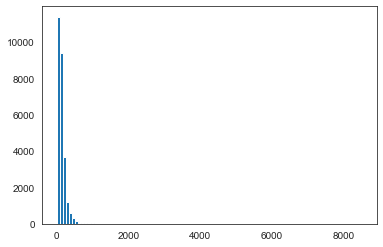

In [151]:
# plot histogram for raw price
plt.hist(full_2019['price'],bins=100)

(array([6.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.800e+01, 7.000e+00,
        1.300e+01, 5.900e+01, 2.800e+01, 7.100e+01, 1.400e+02, 9.600e+01,
        3.430e+02, 1.730e+02, 5.270e+02, 2.560e+02, 6.600e+02, 1.132e+03,
        2.110e+02, 7.740e+02, 1.123e+03, 9.720e+02, 1.045e+03, 9.460e+02,
        9.950e+02, 7.220e+02, 9.730e+02, 1.191e+03, 1.265e+03, 6.460e+02,
        1.085e+03, 9.020e+02, 7.620e+02, 7.790e+02, 1.378e+03, 7.080e+02,
        1.018e+03, 4.740e+02, 1.184e+03, 3.820e+02, 4.000e+02, 8.110e+02,
        2.710e+02, 3.460e+02, 5.150e+02, 1.480e+02, 2.580e+02, 1.050e+02,
        2.390e+02, 7.700e+01, 1.180e+02, 1.790e+02, 2.800e+01, 5.100e+01,
        7.000e+01, 3.900e+01, 4.300e+01, 5.000e+00, 7.500e+01, 1.700e+01,
        1.900e+01, 8.000e+00, 4.800e+01, 9.000e+00, 1.100e+01, 0.000e+00,
        4.000e+00, 3.000e+00, 9.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        1.500e+01, 1.000e+00, 3.000e+0

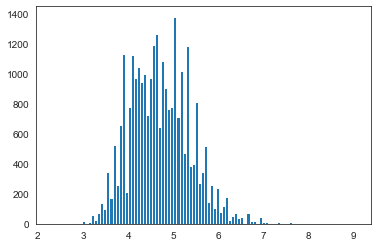

In [152]:
# plot histogram for log price
plt.hist(full_2019['log_price'],bins=100)

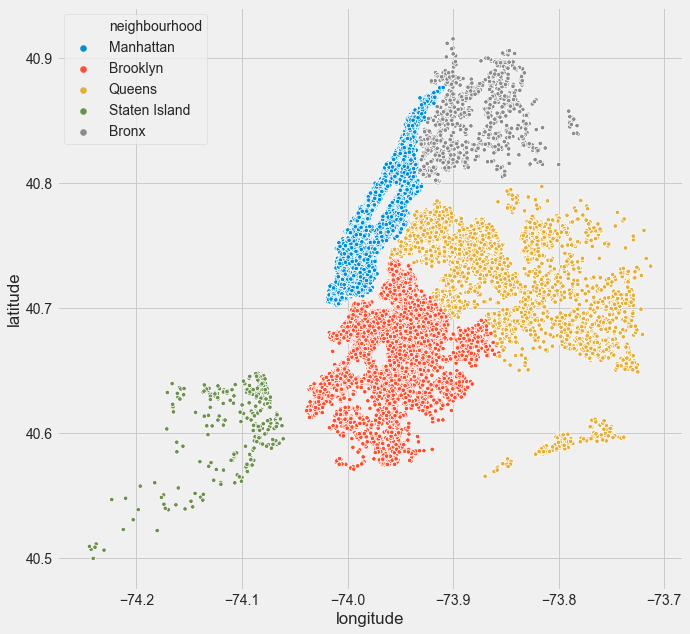

In [123]:
# plot property locations of 2019 data
raw_2019['price'] = raw_2019['price'].str[1:].replace(',', '')
raw_2019['price'] = raw_2019['price'].str.replace(',', '')
raw_2019['price'] = raw_2019['price'].astype(float)
raw_2019 = raw_2019.loc[(raw_2019["price"]!=0)]
raw_2019["log_price"] = np.log(raw_2019["price"])
raw_2019["neighbourhood"] = raw_2019["neighbourhood_group_cleansed"]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue="neighbourhood",s=20, data=raw_2019)